# Backpropagation and Vanishing Gradient Analysis in Neural Networks

In [1]:
# Demonstrating gradient flow, vanishing gradients, and mitigation strategies

import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities
import torch.nn.functional as F  # Import functional interface for neural network operations

torch.manual_seed(42)  # Ensure reproducible results across experiments


In [2]:
# =============================================================================
# Deep Neural Network for Gradient Analysis (Multiple Hidden Layers)
# =============================================================================

class DeepCustomerNet(nn.Module):  # Deep neural network class for gradient flow analysis
    """Deep neural network with multiple hidden layers to demonstrate gradient flow"""
    
    def __init__(self, input_size, hidden_sizes, output_size, activation='sigmoid'):  # Constructor with configurable depth and activation
        super(DeepCustomerNet, self).__init__()  # Initialize parent class
        
        self.activation_type = activation  # Store activation function type
        self.layers = nn.ModuleList()  # Create list to store all layers
        
        # Create input layer
        layer_sizes = [input_size] + hidden_sizes + [output_size]  # Combine all layer sizes
        
        # Create all linear layers
        for i in range(len(layer_sizes) - 1):  # Loop through each layer transition
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))  # Add linear layer
        
        # Store gradients for analysis
        self.layer_gradients = []  # List to store gradient magnitudes per layer
        self.activation_gradients = []  # List to store activation gradients
        
    def forward(self, x):  # Forward pass through all layers
        self.activations = [x]  # Store activations for gradient analysis
        
        for i, layer in enumerate(self.layers[:-1]):  # Process all layers except output
            z = layer(x)  # Linear transformation
            
            # Apply activation function based on type
            if self.activation_type == 'sigmoid':  # Sigmoid activation
                x = torch.sigmoid(z)  # Apply sigmoid
            elif self.activation_type == 'relu':  # ReLU activation
                x = torch.relu(z)  # Apply ReLU
            elif self.activation_type == 'tanh':  # Tanh activation
                x = torch.tanh(z)  # Apply tanh
            
            self.activations.append(x)  # Store activation for analysis
        
        # Output layer (no activation for multiclass logits)
        output = self.layers[-1](x)  # Final linear transformation
        self.activations.append(output)  # Store final output
        
        return output  # Return logits for classification


In [3]:
# =============================================================================
# Customer Dataset (Reusing from Previous Examples)
# =============================================================================

class CustomerDataset(Dataset):  # Customer dataset for gradient analysis
    """Customer behavior dataset for gradient flow demonstration"""
    
    def __init__(self, num_samples=1000):  # Constructor with sample count
        self.len = num_samples  # Store dataset size
        
        # Create 4-class customer behavior dataset
        self.features = torch.zeros((num_samples, 2))  # Initialize features (time, engagement)
        self.labels = torch.zeros(num_samples, dtype=torch.long)  # Initialize class labels
        
        samples_per_class = num_samples // 4  # Samples per class
        
        for i in range(samples_per_class):  # Generate samples for each class
            # Class 0: No Purchase
            self.features[i, :] = torch.tensor([0.3, 0.3]) + 0.2 * torch.randn(2)  # Low time, low engagement
            self.labels[i] = 0  # Set class label
            
            # Class 1: Window Shopping
            self.features[i + samples_per_class, :] = torch.tensor([0.3, 0.8]) + 0.2 * torch.randn(2)  # Low time, high engagement
            self.labels[i + samples_per_class] = 1  # Set class label
            
            # Class 2: Research Purchase
            self.features[i + 2*samples_per_class, :] = torch.tensor([0.8, 0.3]) + 0.2 * torch.randn(2)  # High time, low engagement
            self.labels[i + 2*samples_per_class] = 2  # Set class label
            
            # Class 3: Impulse Purchase
            self.features[i + 3*samples_per_class, :] = torch.tensor([0.8, 0.8]) + 0.2 * torch.randn(2)  # High time, high engagement
            self.labels[i + 3*samples_per_class] = 3  # Set class label
    
    def __getitem__(self, index):  # Get single sample
        return self.features[index], self.labels[index]  # Return feature-label pair
    
    def __len__(self):  # Get dataset size
        return self.len  # Return total samples


In [4]:
# =============================================================================
# Gradient Analysis Functions
# =============================================================================

def analyze_gradients(model, data_loader, criterion):  # Function to analyze gradient magnitudes
    """Analyze gradient flow through layers during backpropagation"""
    
    model.train()  # Set model to training mode
    gradient_magnitudes = {i: [] for i in range(len(model.layers))}  # Dictionary to store gradients per layer
    
    # Process one batch for gradient analysis
    for batch_x, batch_y in data_loader:  # Get one batch
        model.zero_grad()  # Clear previous gradients
        
        # Forward pass
        predictions = model(batch_x)  # Get model predictions
        loss = criterion(predictions, batch_y)  # Calculate loss
        
        # Backward pass
        loss.backward()  # Compute gradients via backpropagation
        
        # Collect gradient magnitudes for each layer
        for i, layer in enumerate(model.layers):  # Loop through all layers
            if layer.weight.grad is not None:  # Check if gradients exist
                grad_magnitude = layer.weight.grad.norm().item()  # Calculate gradient magnitude
                gradient_magnitudes[i].append(grad_magnitude)  # Store gradient magnitude
        
        break  # Only analyze first batch
    
    return gradient_magnitudes  # Return gradient analysis results

def plot_gradient_flow(gradient_results, activation_type, title):  # Function to visualize gradient flow
    """Plot gradient magnitudes across layers to show gradient flow"""
    
    plt.figure(figsize=(12, 6))  # Create figure for gradient visualization
    
    layers = list(gradient_results.keys())  # Get layer indices
    grad_mags = [np.mean(gradient_results[layer]) if gradient_results[layer] else 0 
                for layer in layers]  # Calculate mean gradient magnitudes
    
    # Create bar plot of gradient magnitudes
    bars = plt.bar(range(len(layers)), grad_mags, alpha=0.7, 
                   color='blue' if activation_type == 'sigmoid' else 'green')  # Different colors for activations
    
    plt.xlabel('Layer Index (0=Input Layer, Higher=Deeper)')  # X-axis label
    plt.ylabel('Gradient Magnitude')  # Y-axis label
    plt.title(f'{title} - Activation: {activation_type.upper()}')  # Plot title with activation type
    plt.yscale('log')  # Use log scale for better visibility of small gradients
    plt.grid(True, alpha=0.3)  # Add grid
    
    # Add value labels on bars
    for i, (bar, mag) in enumerate(zip(bars, grad_mags)):  # Add text labels
        if mag > 0:  # Only add label if gradient exists
            plt.text(bar.get_x() + bar.get_width()/2., mag,  # Position text
                    f'{mag:.2e}', ha='center', va='bottom', rotation=45)  # Scientific notation
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plot


In [5]:
# =============================================================================
# Experiment: Compare Sigmoid vs ReLU Activations (Vanishing Gradient Demo)
# =============================================================================

print("=== Backpropagation and Vanishing Gradient Analysis ===")

# Create dataset
dataset = CustomerDataset(num_samples=800)  # Create customer dataset
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Create data loader

# Define deep network architecture
input_size = 2  # Two input features
hidden_sizes = [8, 8, 8, 8, 8]  # Five hidden layers with 8 neurons each (deep network)
output_size = 4  # Four output classes
num_epochs = 50  # Training epochs
learning_rate = 0.01  # Learning rate

print(f"Network architecture: {input_size} -> {' -> '.join(map(str, hidden_sizes))} -> {output_size}")
print(f"Total layers: {len(hidden_sizes) + 1} (5 hidden + 1 output)")
print(f"This deep network is prone to vanishing gradients with sigmoid activation!")


=== Backpropagation and Vanishing Gradient Analysis ===
Network architecture: 2 -> 8 -> 8 -> 8 -> 8 -> 8 -> 4
Total layers: 6 (5 hidden + 1 output)
This deep network is prone to vanishing gradients with sigmoid activation!



--- Training with Sigmoid Activation (Vanishing Gradient Problem) ---
Epoch [10/50], Loss: 0.9857, Accuracy: 0.4487
Epoch [20/50], Loss: 0.9603, Accuracy: 0.4500
Epoch [30/50], Loss: 0.9408, Accuracy: 0.4313
Epoch [40/50], Loss: 0.9405, Accuracy: 0.4662
Epoch [50/50], Loss: 0.9247, Accuracy: 0.5088

Analyzing gradient flow in sigmoid network...


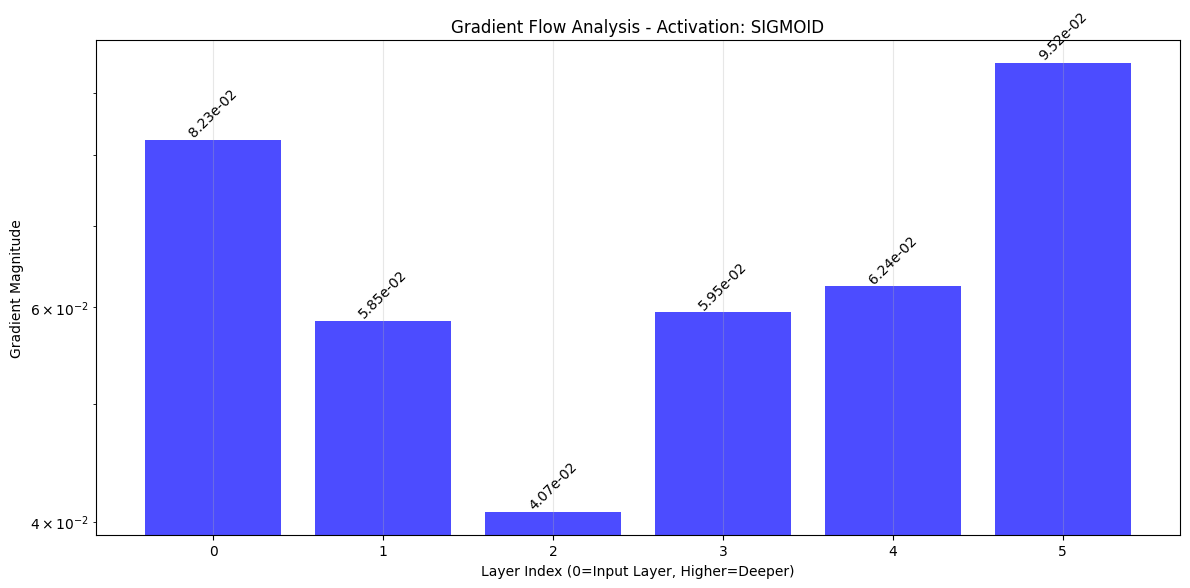

In [6]:
# =============================================================================
# Train with Sigmoid Activation (Prone to Vanishing Gradients)
# =============================================================================

print(f"\n--- Training with Sigmoid Activation (Vanishing Gradient Problem) ---")

# Create sigmoid model
sigmoid_model = DeepCustomerNet(input_size, hidden_sizes, output_size, activation='sigmoid')  # Deep sigmoid network
criterion = nn.CrossEntropyLoss()  # Multiclass loss function
optimizer_sigmoid = torch.optim.Adam(sigmoid_model.parameters(), lr=learning_rate)  # Adam optimizer

# Track training metrics
sigmoid_losses = []  # Track training losses
sigmoid_accuracies = []  # Track training accuracies

for epoch in range(num_epochs):  # Training loop
    sigmoid_model.train()  # Set to training mode
    epoch_loss = 0.0  # Accumulate loss
    correct = 0  # Count correct predictions
    total = 0  # Count total predictions
    
    for batch_x, batch_y in data_loader:  # Process batches
        optimizer_sigmoid.zero_grad()  # Clear gradients
        
        predictions = sigmoid_model(batch_x)  # Forward pass
        loss = criterion(predictions, batch_y)  # Calculate loss
        loss.backward()  # Backward pass (backpropagation)
        optimizer_sigmoid.step()  # Update parameters
        
        epoch_loss += loss.item()  # Accumulate loss
        
        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)  # Get predicted classes
        correct += (predicted_classes == batch_y).sum().item()  # Count correct
        total += batch_y.size(0)  # Count total
    
    avg_loss = epoch_loss / len(data_loader)  # Average loss
    accuracy = correct / total  # Calculate accuracy
    
    sigmoid_losses.append(avg_loss)  # Store loss
    sigmoid_accuracies.append(accuracy)  # Store accuracy
    
    if (epoch + 1) % 10 == 0:  # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Analyze gradients for sigmoid model
print(f"\nAnalyzing gradient flow in sigmoid network...")
sigmoid_gradients = analyze_gradients(sigmoid_model, data_loader, criterion)  # Analyze gradients
plot_gradient_flow(sigmoid_gradients, 'sigmoid', 'Gradient Flow Analysis')  # Plot gradient flow



--- Training with ReLU Activation (Vanishing Gradient Mitigation) ---
Epoch [10/50], Loss: 0.5176, Accuracy: 0.8025
Epoch [20/50], Loss: 0.4923, Accuracy: 0.8063
Epoch [30/50], Loss: 0.4932, Accuracy: 0.8037
Epoch [40/50], Loss: 0.4831, Accuracy: 0.8213
Epoch [50/50], Loss: 0.4847, Accuracy: 0.8150

Analyzing gradient flow in ReLU network...


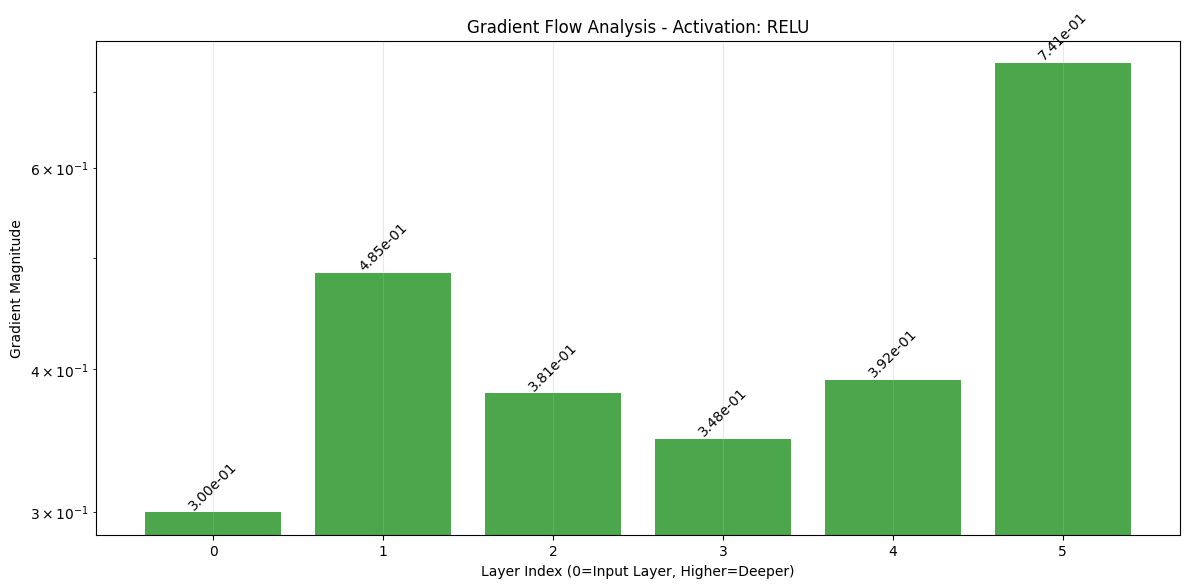

In [7]:
# =============================================================================
# Train with ReLU Activation (Mitigates Vanishing Gradients)
# =============================================================================

print(f"\n--- Training with ReLU Activation (Vanishing Gradient Mitigation) ---")

# Create ReLU model
relu_model = DeepCustomerNet(input_size, hidden_sizes, output_size, activation='relu')  # Deep ReLU network
optimizer_relu = torch.optim.Adam(relu_model.parameters(), lr=learning_rate)  # Adam optimizer

# Track training metrics
relu_losses = []  # Track training losses
relu_accuracies = []  # Track training accuracies

for epoch in range(num_epochs):  # Training loop
    relu_model.train()  # Set to training mode
    epoch_loss = 0.0  # Accumulate loss
    correct = 0  # Count correct predictions
    total = 0  # Count total predictions
    
    for batch_x, batch_y in data_loader:  # Process batches
        optimizer_relu.zero_grad()  # Clear gradients
        
        predictions = relu_model(batch_x)  # Forward pass
        loss = criterion(predictions, batch_y)  # Calculate loss
        loss.backward()  # Backward pass (backpropagation)
        optimizer_relu.step()  # Update parameters
        
        epoch_loss += loss.item()  # Accumulate loss
        
        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)  # Get predicted classes
        correct += (predicted_classes == batch_y).sum().item()  # Count correct
        total += batch_y.size(0)  # Count total
    
    avg_loss = epoch_loss / len(data_loader)  # Average loss
    accuracy = correct / total  # Calculate accuracy
    
    relu_losses.append(avg_loss)  # Store loss
    relu_accuracies.append(accuracy)  # Store accuracy
    
    if (epoch + 1) % 10 == 0:  # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Analyze gradients for ReLU model
print(f"\nAnalyzing gradient flow in ReLU network...")
relu_gradients = analyze_gradients(relu_model, data_loader, criterion)  # Analyze gradients
plot_gradient_flow(relu_gradients, 'relu', 'Gradient Flow Analysis')  # Plot gradient flow


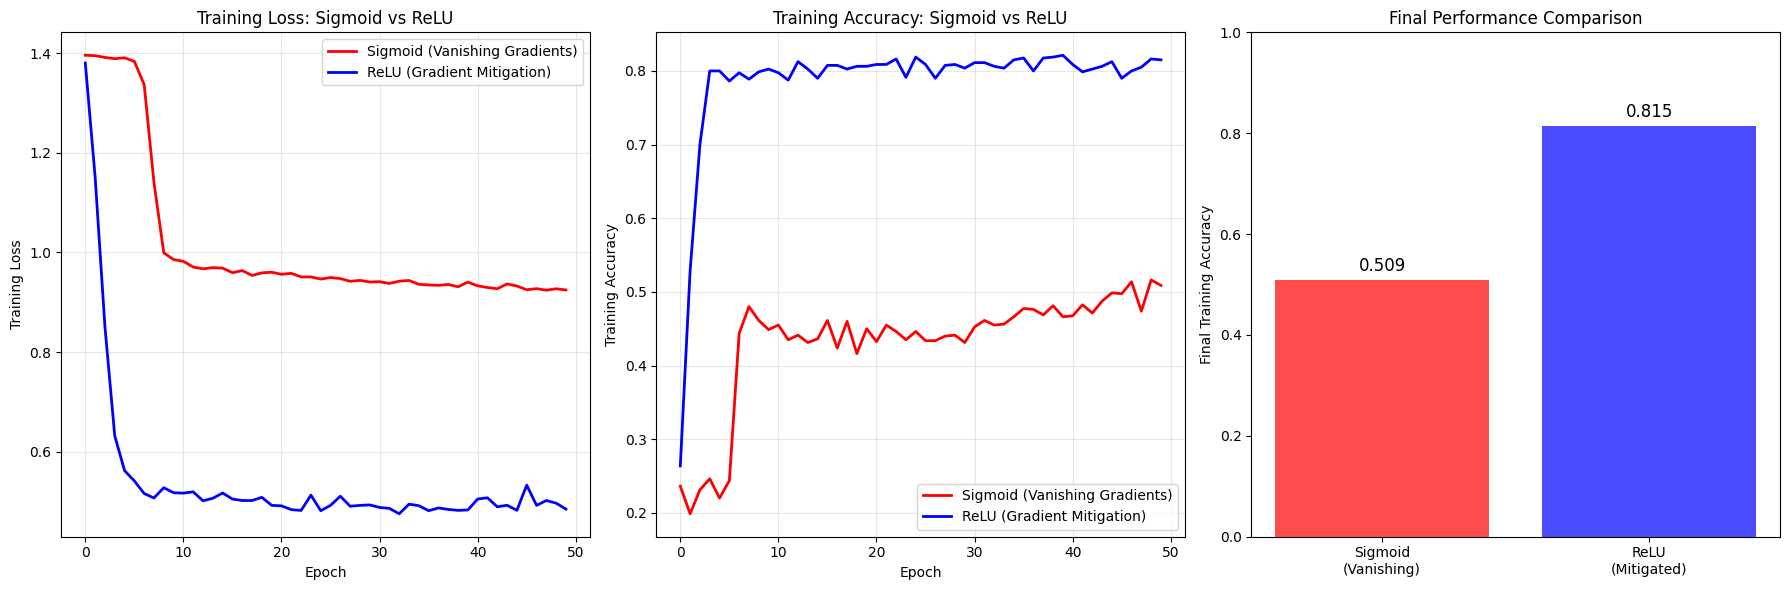

In [8]:
# =============================================================================
# Compare Training Performance: Sigmoid vs ReLU
# =============================================================================

def plot_training_comparison(sigmoid_results, relu_results):  # Function to compare training results
    """Compare training performance between sigmoid and ReLU activations"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 1x3 subplot grid
    
    # Plot 1: Training Loss Comparison
    ax1 = axes[0]  # First subplot
    ax1.plot(sigmoid_results['losses'], label='Sigmoid (Vanishing Gradients)', 
             linewidth=2, color='red')  # Sigmoid loss curve
    ax1.plot(relu_results['losses'], label='ReLU (Gradient Mitigation)', 
             linewidth=2, color='blue')  # ReLU loss curve
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Training Loss')  # Y-axis label
    ax1.set_title('Training Loss: Sigmoid vs ReLU')  # Plot title
    ax1.legend()  # Show legend
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Training Accuracy Comparison
    ax2 = axes[1]  # Second subplot
    ax2.plot(sigmoid_results['accuracies'], label='Sigmoid (Vanishing Gradients)', 
             linewidth=2, color='red')  # Sigmoid accuracy curve
    ax2.plot(relu_results['accuracies'], label='ReLU (Gradient Mitigation)', 
             linewidth=2, color='blue')  # ReLU accuracy curve
    ax2.set_xlabel('Epoch')  # X-axis label
    ax2.set_ylabel('Training Accuracy')  # Y-axis label
    ax2.set_title('Training Accuracy: Sigmoid vs ReLU')  # Plot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Final Performance Comparison
    ax3 = axes[2]  # Third subplot
    activations = ['Sigmoid\n(Vanishing)', 'ReLU\n(Mitigated)']  # Activation types
    final_accuracies = [sigmoid_results['accuracies'][-1], relu_results['accuracies'][-1]]  # Final accuracies
    
    bars = ax3.bar(activations, final_accuracies, color=['red', 'blue'], alpha=0.7)  # Bar chart
    ax3.set_ylabel('Final Training Accuracy')  # Y-axis label
    ax3.set_title('Final Performance Comparison')  # Plot title
    ax3.set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, final_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                f'{accuracy:.3f}', ha='center', va='bottom', fontsize=12)  # Format text
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plots

# Store results for comparison
sigmoid_results = {'losses': sigmoid_losses, 'accuracies': sigmoid_accuracies}  # Sigmoid results
relu_results = {'losses': relu_losses, 'accuracies': relu_accuracies}  # ReLU results

# Generate comparison plots
plot_training_comparison(sigmoid_results, relu_results)  # Compare training performance


In [9]:
# =============================================================================
# Demonstrate Chain Rule in Action (Manual Gradient Computation)
# =============================================================================

def demonstrate_chain_rule():  # Function to demonstrate chain rule manually
    """Demonstrate the chain rule concept from backpropagation"""
    
    print(f"\n=== Chain Rule Demonstration (The Math Behind Backpropagation) ===")
    
    # Simple example: f(g(x)) where f(z) = z², g(x) = 2x + 1
    x = torch.tensor(3.0, requires_grad=True)  # Input value with gradient tracking
    
    # Forward pass (function composition)
    z = 2 * x + 1  # g(x) = 2x + 1
    y = z ** 2     # f(z) = z²
    
    print(f"Forward pass:")
    print(f"  x = {x.item()}")
    print(f"  z = g(x) = 2x + 1 = {z.item()}")
    print(f"  y = f(z) = z² = {y.item()}")
    
    # Backward pass (automatic differentiation)
    y.backward()  # Compute gradients automatically
    
    print(f"\nAutomatic differentiation (PyTorch):")
    print(f"  dy/dx = {x.grad.item()}")
    
    # Manual chain rule calculation
    # dy/dx = (dy/dz) * (dz/dx) = 2z * 2 = 4z = 4(2x + 1)
    manual_gradient = 4 * (2 * x.item() + 1)  # Manual calculation
    
    print(f"\nManual chain rule calculation:")
    print(f"  dy/dz = 2z = 2 * {z.item()} = {2 * z.item()}")
    print(f"  dz/dx = 2")
    print(f"  dy/dx = (dy/dz) * (dz/dx) = {2 * z.item()} * 2 = {manual_gradient}")
    
    print(f"\nVerification:")
    print(f"  PyTorch gradient: {x.grad.item()}")
    print(f"  Manual gradient:  {manual_gradient}")
    print(f"  Match: {'✓' if abs(x.grad.item() - manual_gradient) < 1e-6 else '✗'}")

# Run chain rule demonstration
demonstrate_chain_rule()  # Demonstrate chain rule manually



=== Chain Rule Demonstration (The Math Behind Backpropagation) ===
Forward pass:
  x = 3.0
  z = g(x) = 2x + 1 = 7.0
  y = f(z) = z² = 49.0

Automatic differentiation (PyTorch):
  dy/dx = 28.0

Manual chain rule calculation:
  dy/dz = 2z = 2 * 7.0 = 14.0
  dz/dx = 2
  dy/dx = (dy/dz) * (dz/dx) = 14.0 * 2 = 28.0

Verification:
  PyTorch gradient: 28.0
  Manual gradient:  28.0
  Match: ✓


In [10]:
# =============================================================================
# Statistical Analysis of Gradient Results
# =============================================================================

print(f"\n=== Statistical Analysis: Vanishing Gradient Problem ===")

# Compare gradient magnitudes between sigmoid and ReLU
print(f"\nGradient Magnitude Analysis:")

# Calculate average gradient magnitudes for each layer
sigmoid_avg_grads = [np.mean(sigmoid_gradients[i]) if sigmoid_gradients[i] else 0 
                    for i in range(len(sigmoid_gradients))]  # Sigmoid average gradients
relu_avg_grads = [np.mean(relu_gradients[i]) if relu_gradients[i] else 0 
                 for i in range(len(relu_gradients))]  # ReLU average gradients

print(f"\nLayer-wise Gradient Comparison:")
for i, (sig_grad, relu_grad) in enumerate(zip(sigmoid_avg_grads, relu_avg_grads)):  # Compare gradients
    ratio = relu_grad / sig_grad if sig_grad > 0 else float('inf')  # Calculate ratio
    print(f"  Layer {i}: Sigmoid={sig_grad:.2e}, ReLU={relu_grad:.2e}, Ratio={ratio:.1f}x")

# Performance comparison
sigmoid_final = sigmoid_accuracies[-1]  # Final sigmoid accuracy
relu_final = relu_accuracies[-1]  # Final ReLU accuracy
improvement = relu_final - sigmoid_final  # Accuracy improvement

print(f"\nPerformance Impact:")
print(f"• Sigmoid final accuracy: {sigmoid_final:.4f} ({sigmoid_final*100:.2f}%)")
print(f"• ReLU final accuracy: {relu_final:.4f} ({relu_final*100:.2f}%)")
print(f"• Improvement with ReLU: {improvement:.4f} ({improvement*100:.2f} percentage points)")



=== Statistical Analysis: Vanishing Gradient Problem ===

Gradient Magnitude Analysis:

Layer-wise Gradient Comparison:
  Layer 0: Sigmoid=8.23e-02, ReLU=3.00e-01, Ratio=3.6x
  Layer 1: Sigmoid=5.85e-02, ReLU=4.85e-01, Ratio=8.3x
  Layer 2: Sigmoid=4.07e-02, ReLU=3.81e-01, Ratio=9.4x
  Layer 3: Sigmoid=5.95e-02, ReLU=3.48e-01, Ratio=5.9x
  Layer 4: Sigmoid=6.24e-02, ReLU=3.92e-01, Ratio=6.3x
  Layer 5: Sigmoid=9.52e-02, ReLU=7.41e-01, Ratio=7.8x

Performance Impact:
• Sigmoid final accuracy: 0.5088 (50.88%)
• ReLU final accuracy: 0.8150 (81.50%)
• Improvement with ReLU: 0.3062 (30.62 percentage points)


In [16]:
# =============================================================================
# Key Insights and Summary
# =============================================================================

print(f"\n=== Key Insights: Backpropagation and Vanishing Gradients ===")

print(f"\nBackpropagation Process:")
print(f"1. Forward Pass: Compute predictions through network layers")
print(f"2. Loss Calculation: Compare predictions with true labels")
print(f"3. Backward Pass: Use chain rule to compute gradients")
print(f"4. Parameter Update: Use gradients to update weights")

print(f"\nVanishing Gradient Problem:")
print(f"• Deep networks with sigmoid activations suffer from vanishing gradients")
print(f"• Each sigmoid derivative is < 1, multiplication chains approach 0")
print(f"• Early layers receive tiny gradients and stop learning")
print(f"• Result: Poor training performance and slow convergence")

print(f"\nMitigation Strategies:")
print(f"• ReLU Activation: Derivative is either 0 or 1 (doesn't vanish)")
print(f"• Better Optimizers: Adam, RMSprop handle gradients better than SGD")
print(f"• Batch Normalization: Normalizes inputs to prevent saturation")
print(f"• Skip Connections: Allow gradients to flow around layers (ResNets)")

print(f"\nPyTorch Advantages:")
print(f"• Automatic differentiation handles backpropagation automatically")
print(f"• .backward() computes all gradients using efficient chain rule")
print(f"• Built-in optimizers handle parameter updates")
print(f"• We don't need to manually implement backpropagation!")

print(f"\nFinal Recommendation: Use ReLU activations in hidden layers")
print(f"and let PyTorch handle the complex backpropagation mathematics!")


=== Key Insights: Backpropagation and Vanishing Gradients ===

Backpropagation Process:
1. Forward Pass: Compute predictions through network layers
2. Loss Calculation: Compare predictions with true labels
3. Backward Pass: Use chain rule to compute gradients
4. Parameter Update: Use gradients to update weights

Vanishing Gradient Problem:
• Deep networks with sigmoid activations suffer from vanishing gradients
• Each sigmoid derivative is < 1, multiplication chains approach 0
• Early layers receive tiny gradients and stop learning
• Result: Poor training performance and slow convergence

Mitigation Strategies:
• ReLU Activation: Derivative is either 0 or 1 (doesn't vanish)
• Better Optimizers: Adam, RMSprop handle gradients better than SGD
• Batch Normalization: Normalizes inputs to prevent saturation
• Skip Connections: Allow gradients to flow around layers (ResNets)

PyTorch Advantages:
• Automatic differentiation handles backpropagation automatically
• .backward() computes all gra